In [8]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from tqdm import tqdm

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Pair Programming Random Forest


### Ana G y Ana C

Hasta ahora hemos ajustado el modelo usando una Regresión Logística, pero como hemos aprendido, podemos usar el Random Forest en este tipo de problemas. 

Los objetivos de este pair programming :

- Ajustad un modelo de Random Forest a nuestros datos.
- Calculad las métricas a nuestro nuevo modelo.
- Comparad las métricas con los modelos hechos hasta ahora. ¿Cuál es mejor?

In [9]:
df_esta = pd.read_csv("../data-log/02-df_estandarizadas_codificadas.csv", index_col=0)
df_esta.drop('id', axis=1, inplace=True)
df_esta.head(2)

,sex,education,is_smoking,BPMeds,prevalentStroke,prevalentHyp,diabetes,TenYearCHD,age,cigsPerDay,glucose,totChol,sysBP,diaBP,BMI,heartRate
0,1,2.0,1,0.0,0.0,0.0,0.0,1.0,1.071429,0.15,0.153846,-0.224138,0.722222,0.193548,0.136595,1.000000
1,1,1.0,1,0.0,0.0,0.0,0.0,0.0,-0.214286,0.50,1.230769,0.275862,-0.462963,-0.709677,-1.009027,0.866667


In [10]:
df_noesta = pd.read_csv("../data-log/02-df_codifcadas_no_estandarizadas.csv", index_col=0)
df_noesta.drop('id', axis=1, inplace=True)
df_noesta.head(2)

,sex,education,age,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,glucose,totChol,sysBP,diaBP,BMI,heartRate,TenYearCHD
0,1,2.0,64.0,1,3.0,0.0,0.0,0.0,0.0,80.0,221.0,148.0,85.0,26.060925,90.0,1.0
1,1,1.0,46.0,1,10.0,0.0,0.0,0.0,0.0,94.0,250.0,116.0,71.0,20.350000,88.0,0.0


In [11]:
df_bal = pd.read_csv("../data-log/02-bal_est_cod.csv", index_col=0)
df_bal.dropna(inplace=True)
df_bal.isnull().sum()

sex                0
education          0
is_smoking         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
age                0
cigsPerDay         0
glucose            0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
TenYearCHD         0
dtype: int64

---

# 1. Datos  no estandarizadas, no balanceado

In [12]:
# separamos los datos en X e y

X1 = df_noesta.drop("TenYearCHD", axis = 1)
y1 = df_noesta["TenYearCHD"]

In [13]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train, x_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [14]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [2,4, 6, 10, 12, 14], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 

In [15]:
gs_rf = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1) # para que no nos printee ningún mensaje en pantalla
        

In [16]:
# ajustamos el modelo que acabamos de definir en el GridSearch
# 🚨 Esta celda puede tardar en ejecutarse

gs_rf.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 4, 6, 10, 12, 14],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             verbose=-1)

In [17]:
# saquemos ahora cual es nuestro mejor bosque

bosque = gs_rf.best_estimator_
bosque

RandomForestClassifier(max_depth=14, max_features=3, min_samples_leaf=10,
                       min_samples_split=10, random_state=42)

In [19]:
y_pred_test_rf = bosque.predict(x_test)
y_pred_train_rf = bosque.predict(x_train)

In [20]:
def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    

    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kapppa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [61]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results = metricas(y_test, y_pred_test_rf,y_train,  y_pred_train_rf, "Random Forest NO Estandarizada Codificada")
dt_results

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.840708,0.500000,0.009259,0.018182,0.012462,test,Random Forest NO Estandarizada Codificada
1,0.856932,0.941176,0.039702,0.076190,0.064942,train,Random Forest NO Estandarizada Codificada


In [62]:
# igual que en la clase de decision tree, juntemos estos resultados con los obtenidos en los modelos que hemos hecho hasta ahora
# lo primero que tenemos que hacer es cargar el csv con todos los resultados que guardamos en el jupyter anterior

df_LR_DT_results = pd.read_csv('../data-log/05-Metricas_Decision_Tree.csv', index_col = 0)
df_LR_DT_results

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.842183,0.571429,0.037037,0.069565,0.051165,test,Random Forest Estandarizada Codificada
1,0.861357,0.965517,0.069479,0.129630,0.111912,train,Random Forest Estandarizada Codificada
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada
6,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
7,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I


In [63]:
# concatenamos el csv anterior con los resultados obtenidos en este modelo

df_todos_resultados = pd.concat([dt_results, df_LR_DT_results], axis = 0)
df_todos_resultados

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.840708,0.500000,0.009259,0.018182,0.012462,test,Random Forest NO Estandarizada Codificada
1,0.856932,0.941176,0.039702,0.076190,0.064942,train,Random Forest NO Estandarizada Codificada
0,0.842183,0.571429,0.037037,0.069565,0.051165,test,Random Forest Estandarizada Codificada
1,0.861357,0.965517,0.069479,0.129630,0.111912,train,Random Forest Estandarizada Codificada
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada


In [ ]:
df_todos_resultados.to_csv('../data-log/05-Metricas_Decision_Tree.csv')

Importancia de las variables

In [25]:

# vamos a crearnos un dataframe, igual que hicimos en la clase anterior con la importancia de cada una de las variables incluidas en el modelo

importancia_predictores = pd.DataFrame(
                            {'predictor': x_train.columns,
                             'importancia': bosque.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
2,age,0.166295
11,sysBP,0.148113
9,glucose,0.112186
12,diaBP,0.111163
10,totChol,0.105254
13,BMI,0.099155
14,heartRate,0.077592
4,cigsPerDay,0.060400
7,prevalentHyp,0.031800
1,education,0.029813


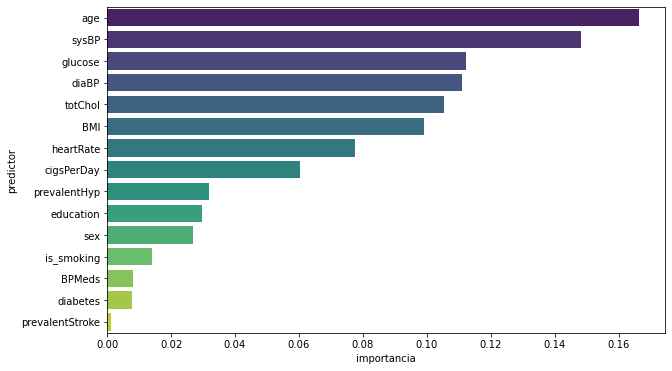

In [26]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");
plt.show()

---

# 2. Estandarizadas y no balanceado

In [27]:
# separamos los datos en X e y

X2 = df_esta.drop("TenYearCHD", axis = 1)
y2 = df_esta["TenYearCHD"]

In [28]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state = 42)

In [29]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param2 = {"max_depth": [2,4, 6, 10, 12, 14], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 

In [30]:
gs_rf2 = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42), # tipo de modelo que queremos hacer
            param_grid= param2, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1) # para que no nos printee ningún mensaje en pantalla
        

In [31]:
# ajustamos el modelo que acabamos de definir en el GridSearch
# 🚨 Esta celda puede tardar en ejecutarse

gs_rf2.fit(x_train2, y_train2)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 4, 6, 10, 12, 14],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             verbose=-1)

In [32]:
# saquemos ahora cual es nuestro mejor bosque

bosque2 = gs_rf2.best_estimator_
bosque2

RandomForestClassifier(max_depth=10, max_features=4, min_samples_leaf=10,
                       min_samples_split=10, random_state=42)

In [34]:
y_pred_test_rf2 = bosque2.predict(x_test2)
y_pred_train_rf2 = bosque2.predict(x_train2)

In [56]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results2 = metricas(y_test2, y_pred_test_rf2,y_train2,  y_pred_train_rf2, "Random Forest Estandarizada Codificada")
dt_results2

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.842183,0.571429,0.037037,0.069565,0.051165,test,Random Forest Estandarizada Codificada
1,0.861357,0.965517,0.069479,0.129630,0.111912,train,Random Forest Estandarizada Codificada


In [57]:
# igual que en la clase de decision tree, juntemos estos resultados con los obtenidos en los modelos que hemos hecho hasta ahora
# lo primero que tenemos que hacer es cargar el csv con todos los resultados que guardamos en el jupyter anterior

df_LR_DT_results2 = pd.read_csv('../data-log/05-Metricas_Decision_Tree.csv', index_col = 0)
df_LR_DT_results2

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada
6,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
7,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I
8,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree NO Esta II
9,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree NO Esta II


In [58]:
# concatenamos el csv anterior con los resultados obtenidos en este modelo

df_todos_resultados2 = pd.concat([dt_results2, df_LR_DT_results2], axis = 0)
df_todos_resultados2

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.842183,0.571429,0.037037,0.069565,0.051165,test,Random Forest Estandarizada Codificada
1,0.861357,0.965517,0.069479,0.129630,0.111912,train,Random Forest Estandarizada Codificada
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada
6,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
7,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I


In [60]:
df_todos_resultados2.to_csv('../data-log/05-Metricas_Decision_Tree.csv')

Importancia de las variables

In [39]:
# vamos a crearnos un dataframe, igual que hicimos en la clase anterior con la importancia de cada una de las variables incluidas en el modelo
importancia_predictores2= pd.DataFrame(
                            {'predictor': x_train2.columns,
                             'importancia': bosque2.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores2.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores2

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
7,age,0.171529
11,sysBP,0.151380
9,glucose,0.132908
10,totChol,0.106147
12,diaBP,0.104975
13,BMI,0.101076
14,heartRate,0.064769
8,cigsPerDay,0.060484
5,prevalentHyp,0.032544
0,sex,0.028718


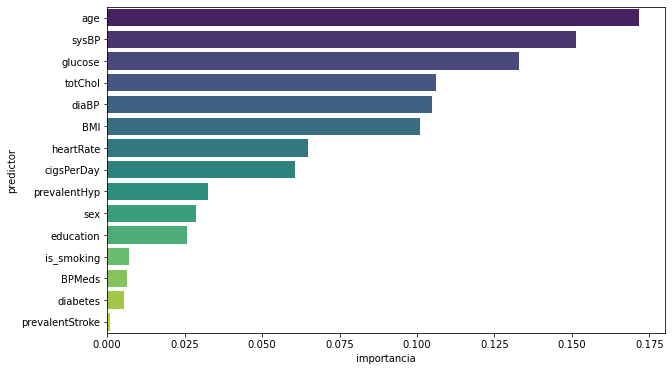

In [40]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores2, palette="viridis");
plt.show()

---

# 3. Balanceada, estandarizadas

In [41]:
# separamos los datos en X e y

X3 = df_noesta.drop("TenYearCHD", axis = 1)
y3 = df_noesta["TenYearCHD"]

In [42]:
# y dividir nuestros datos en train y test para poder evaluar la bondad de nuestro modelo

x_train3, x_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.2, random_state = 42)

In [43]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param3 = {"max_depth": [2,4, 6, 10, 12, 14], # teniendo en cuenta que teníamos overfitting tendremos que reducir la profundidad del modelo, la nuestra anterior era de 17. Bajaremos mucho este valor ya que teníamos un overfitting muy claro
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 

In [44]:
gs_rf3 = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42), # tipo de modelo que queremos hacer
            param_grid= param3, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=-1) # para que no nos printee ningún mensaje en pantalla
        

In [45]:
# ajustamos el modelo que acabamos de definir en el GridSearch
# 🚨 Esta celda puede tardar en ejecutarse

gs_rf3.fit(x_train3, y_train3)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [2, 4, 6, 10, 12, 14],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]},
             verbose=-1)

In [46]:
# saquemos ahora cual es nuestro mejor bosque

bosque3 = gs_rf3.best_estimator_
bosque3

RandomForestClassifier(max_depth=14, max_features=3, min_samples_leaf=10,
                       min_samples_split=10, random_state=42)

In [47]:
y_pred_test_rf3 = bosque3.predict(x_test3)
y_pred_train_rf3 = bosque3.predict(x_train3)

In [48]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results3 = metricas(y_test3, y_pred_test_rf3,y_train3,  y_pred_train_rf3, "Random Forest Balanceada Estandarizada")
dt_results3

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.840708,0.500000,0.009259,0.018182,0.012462,test,Random Forest
1,0.856932,0.941176,0.039702,0.076190,0.064942,train,Random Forest


In [54]:
# igual que en la clase de decision tree, juntemos estos resultados con los obtenidos en los modelos que hemos hecho hasta ahora
# lo primero que tenemos que hacer es cargar el csv con todos los resultados que guardamos en el jupyter anterior

df_LR_DT_results3 = pd.read_csv('../data-log/05-Metricas_Decision_Tree.csv', index_col = 0)
df_LR_DT_results3

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada
6,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
7,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I
8,0.839233,0.428571,0.027778,0.052174,0.033430,test,DecisionTree NO Esta II
9,0.854351,0.605263,0.057072,0.104308,0.080768,train,DecisionTree NO Esta II


In [59]:
# concatenamos el csv anterior con los resultados obtenidos en este modelo

df_todos_resultados3 = pd.concat([dt_results3, df_LR_DT_results2], axis = 0)
df_todos_resultados3

,accuracy,precision,recall,f1,kapppa,set,modelo
0,0.840708,0.500000,0.009259,0.018182,0.012462,test,Random Forest
1,0.856932,0.941176,0.039702,0.076190,0.064942,train,Random Forest
0,0.716495,0.568627,0.324022,0.412811,0.244013,test,Regresión logistica Balanceada Estandarizada C...
1,0.723322,0.585752,0.313559,0.408464,0.248900,train,Regresión logistica Balanceada Estandarizada C...
2,0.805310,0.357143,0.277778,0.312500,0.201157,test,Regresión logistica Estandarizada Codificada
3,0.815265,0.360000,0.312655,0.334661,0.228020,train,Regresión logistica Estandarizada Codificada
4,0.846608,0.750000,0.055556,0.103448,0.083307,test,Regresión logistica NO Estandarizada Codificada
5,0.861357,0.775510,0.094293,0.168142,0.140448,train,Regresión logistica NO Estandarizada Codificada
6,0.756637,0.275591,0.324074,0.297872,0.151845,test,Decission Tree NO Esta I
7,1.000000,1.000000,1.000000,1.000000,1.000000,train,Decission Tree NO Esta I


In [ ]:
df_todos_resultados3.to_csv('../data-log/05-Metricas_Decision_Tree.csv')

Importancia de las variables

In [52]:

# vamos a crearnos un dataframe, igual que hicimos en la clase anterior con la importancia de cada una de las variables incluidas en el modelo

importancia_predictores3 = pd.DataFrame(
                            {'predictor': x_train3.columns,
                             'importancia': bosque3.feature_importances_}
                            )


# ordenamos de mayor a menor los resultados
importancia_predictores3.sort_values(by=["importancia"], ascending=False, inplace = True)

# printeamos los resultados
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores3

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
2,age,0.166295
11,sysBP,0.148113
9,glucose,0.112186
12,diaBP,0.111163
10,totChol,0.105254
13,BMI,0.099155
14,heartRate,0.077592
4,cigsPerDay,0.060400
7,prevalentHyp,0.031800
1,education,0.029813


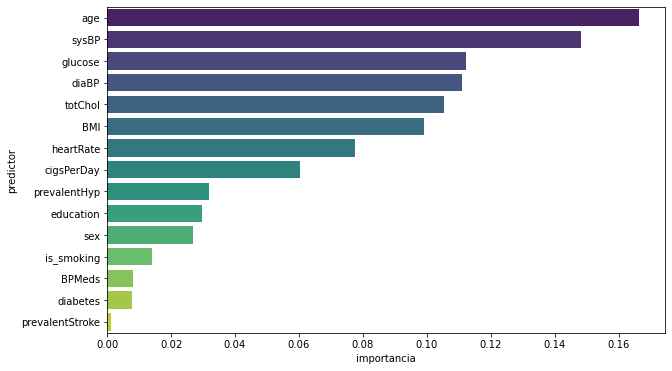

In [53]:
# por último ploteamos los resultados para verlo de una forma más amigable. 

plt.figure(figsize=(10,6))
sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores3, palette="viridis");
plt.show()